# Economic Well-Being 
# By Mohamed Eltayeb

# -------------------------------------------------------------------------------------------------------------- 

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from category_encoders import CountEncoder
from sklearn.compose import TransformedTargetRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor

# Read the training and testing data


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
ID = test_df['ID']

# Exploratory data analysis

## Features:

* 'ghsl_water_surface' - the fraction of land within 5km of the cluster that is classified as water surface
* 'ghsl built pre_1975' - the fraction of land within 5km of the cluster that is classified as built-up before 1975
* 'ghsl built 1975 to 1990'
* 'ghsl built 1990 to 2000',
* 'ghsl built 2000 to 2014',
* 'ghsl not built up' - land that was never built up
* 'ghsl pop density' - population density for the surrounding area (5km radius)
* 'Landcover crops_fraction' - the fraction of land within 5km of the cluster that is classified as cropland
* 'landcover urban_fraction' - the fraction of land within 5km of the cluster that is classified as urban
* 'Landcover water permanent 10km fraction' - the fraction of land within 10km of the cluster that is classified as permanent water
* 'Landcover water seasonal 10km fraction' - the fraction of land within 10km of the cluster that is classified as seasonal water
* 'Nighttime_lights' - a classic indicator of economic activity
* 'Dist to capital' - distance to the countries capital
* 'Dist to shoreline' - distance to the nearest ocean shoreline
* ‘urban or rural’: Is the cluster in an urban (‘U’) or rural (‘R’) setting

In [3]:
train_df.shape

(21454, 19)

In [4]:
test_df.shape

(7194, 18)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       21454 non-null  object 
 1   country                                  21454 non-null  object 
 2   year                                     21454 non-null  int64  
 3   urban_or_rural                           21454 non-null  object 
 4   ghsl_water_surface                       21454 non-null  float64
 5   ghsl_built_pre_1975                      21454 non-null  float64
 6   ghsl_built_1975_to_1990                  21454 non-null  float64
 7   ghsl_built_1990_to_2000                  21454 non-null  float64
 8   ghsl_built_2000_to_2014                  21454 non-null  float64
 9   ghsl_not_built_up                        21454 non-null  float64
 10  ghsl_pop_density                         21454

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       7194 non-null   object 
 1   country                                  7194 non-null   object 
 2   year                                     7194 non-null   int64  
 3   urban_or_rural                           7194 non-null   object 
 4   ghsl_water_surface                       7194 non-null   float64
 5   ghsl_built_pre_1975                      7194 non-null   float64
 6   ghsl_built_1975_to_1990                  7194 non-null   float64
 7   ghsl_built_1990_to_2000                  7194 non-null   float64
 8   ghsl_built_2000_to_2014                  7194 non-null   float64
 9   ghsl_not_built_up                        7194 non-null   float64
 10  ghsl_pop_density                         7194 no

###### No missing values.

In [7]:
train_df.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [8]:
test_df.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,Burkina Faso,2010,U,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,Zambia,2007,R,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


In [9]:
train_df['country'].value_counts()

Nigeria                     2695
Kenya                       2626
Tanzania                    2450
Malawi                      1957
Ethiopia                    1721
Ghana                       1419
Mali                        1295
Cameroon                    1041
Rwanda                       984
Senegal                      903
Mozambique                   879
Lesotho                      794
Sierra Leone                 785
Guinea                       593
Cote d'Ivoire                481
Togo                         330
Swaziland                    270
Central African Republic     231
Name: country, dtype: int64

In [10]:
test_df['country'].value_counts()

Uganda                          1584
Zimbabwe                        1189
Zambia                          1038
Burkina Faso                     997
Angola                           855
Democratic Republic of Congo     785
Benin                            746
Name: country, dtype: int64

###### Notice that the train and test sets have different countries.

In [11]:
train_df.describe()

,year,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
count,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000
mean,2010.060874,0.028259,0.038222,0.028644,0.012689,0.018386,0.873800,95.756775,21.034265,13.999061,1.486849,0.714891,8.506543,289.722268,402.608539,0.350736
std,4.799579,0.097490,0.113562,0.077367,0.032745,0.040421,0.239294,209.704761,16.751106,23.715485,6.550171,2.383701,21.090378,238.811778,321.517285,0.194376
min,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105306,0.112080,0.000000
25%,2008.000000,0.000000,0.000000,0.000000,0.000043,0.000124,0.897867,3.848533,5.610515,0.798841,0.000000,0.001325,0.000000,115.890873,126.379463,0.195772
50%,2011.000000,0.000000,0.000198,0.000709,0.001001,0.001871,0.991919,17.632672,18.509291,2.770159,0.000516,0.029151,0.137333,256.736472,327.271973,0.293574
75%,2014.000000,0.000000,0.007987,0.009868,0.008128,0.014936,0.999532,63.225683,33.590293,12.621501,0.152364,0.381969,4.830194,401.153071,643.910675,0.499003
max,2016.000000,0.969956,0.877116,0.685010,0.515534,0.649159,1.000000,1741.256516,80.064918,98.784092,99.164018,56.201637,382.932769,1897.351575,1769.523906,1.000000


In [12]:
test_df.describe()

,year,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
count,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000
mean,2010.899778,0.023317,0.049325,0.025364,0.016767,0.018319,0.866908,93.147365,21.285033,14.318006,2.212083,0.634295,11.508951,332.979023,686.113119
std,3.651409,0.087915,0.132582,0.057233,0.038079,0.039703,0.252557,211.196451,14.916804,24.510227,8.683106,2.383202,37.313751,341.906808,368.546747
min,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437825,0.898246
25%,2010.000000,0.000000,0.000000,0.000000,0.000019,0.000075,0.889836,1.071279,7.855023,0.459067,0.000000,0.001444,0.000000,101.060708,409.104775
50%,2011.000000,0.000000,0.000089,0.000320,0.000720,0.001359,0.994922,12.290615,21.105082,2.087011,0.002072,0.052594,0.000000,241.468141,759.849023
75%,2014.000000,0.000000,0.008020,0.010774,0.012036,0.015915,0.999738,66.695301,31.998608,14.174194,0.222664,0.351605,5.543974,415.621994,954.987511
max,2016.000000,0.991100,0.894608,0.506349,0.275297,0.359931,1.000000,1902.876955,74.401875,97.210607,96.978486,47.232629,403.455783,1908.105037,1748.559242


## Visualization

<AxesSubplot:>

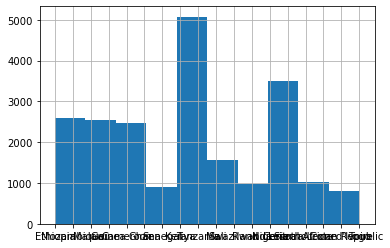

In [13]:
#Country
train_df['country'].hist()

###### We will convert this feature into a frequency one.

### Urban_or_Rural

[]

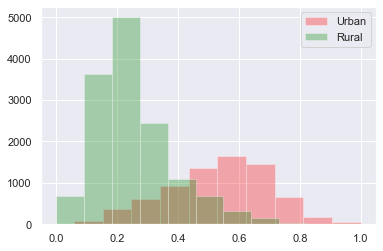

In [14]:
sns.set()
plt.hist(train_df[train_df['urban_or_rural'] == 'U'].Target, color='red', alpha = 0.3, label = 'Urban')
plt.hist(train_df[train_df['urban_or_rural'] == 'R'].Target, color='green', alpha=0.3, label = 'Rural')
plt.legend()
plt.plot()

###### We can see that most of the Rural areas has a Wealth Index less than 0.5, and the peak of the index is approximately at 0.25.

### Ghsl_built_pre_1975 --- ghsl_built_1975_to_1990

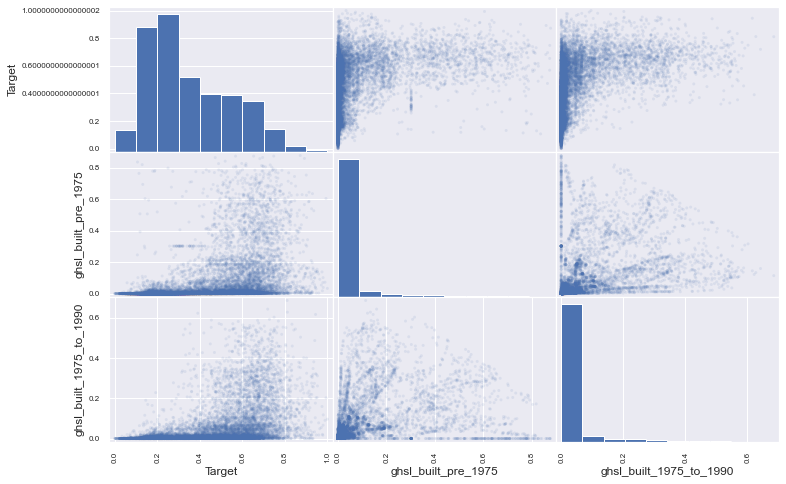

In [15]:
attributes = ["Target", "ghsl_built_pre_1975", "ghsl_built_1975_to_1990"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8), alpha=0.1);

### Ghsl_built_1990_to_2000 --- ghsl_built_2000_to_2014 --- ghsl_not_built_up

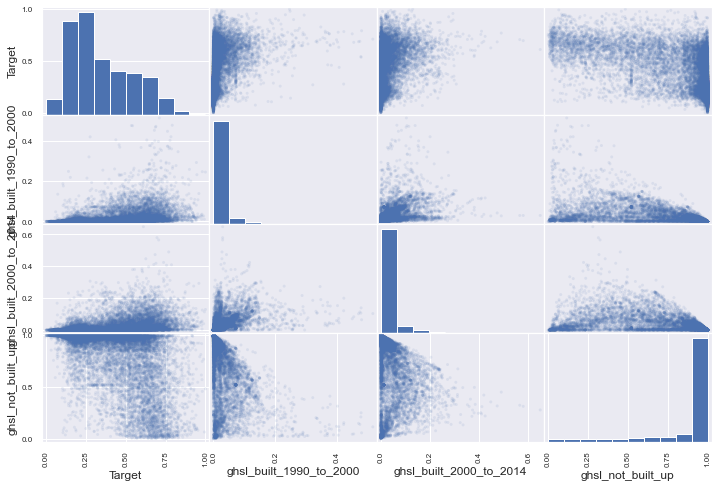

In [16]:
attributes = ["Target" ,"ghsl_built_1990_to_2000","ghsl_built_2000_to_2014","ghsl_not_built_up"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8), alpha=0.1);

### Ghsl_water_surface --- ghsl_pop_density

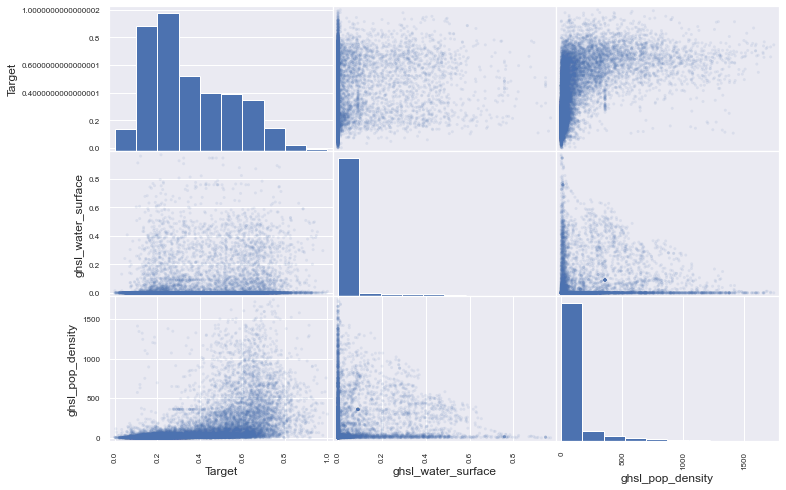

In [17]:
attributes = ["Target", "ghsl_water_surface", "ghsl_pop_density"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8), alpha=0.1);

### landcover_crops_fraction --- landcover_urban_fraction

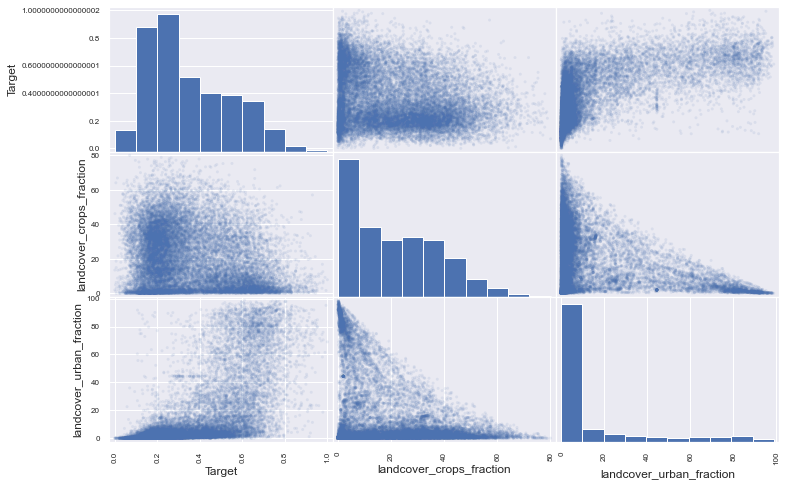

In [18]:
attributes = ["Target", "landcover_crops_fraction", "landcover_urban_fraction"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8),alpha=0.1);

### landcover_water_permanent_10km_fraction --- landcover_water_seasonal_10km_fraction

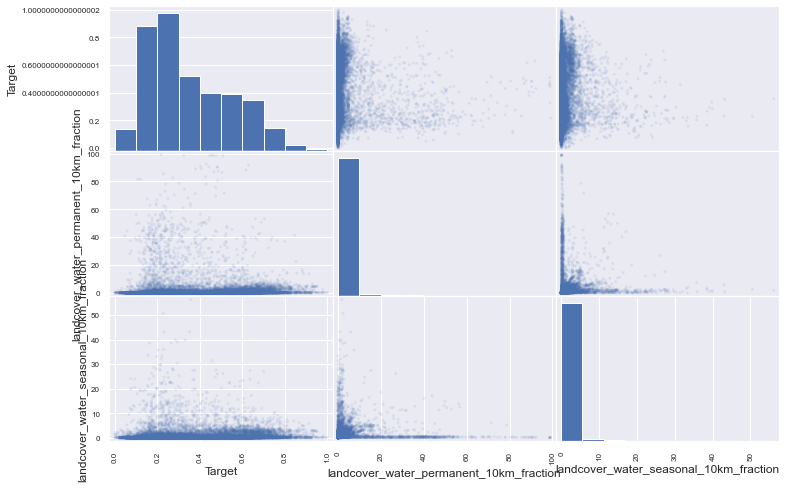

In [19]:
attributes = ["Target", "landcover_water_permanent_10km_fraction", "landcover_water_seasonal_10km_fraction"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8),alpha=0.1);

### Nighttime_lights --- dist_to_capital --- dist_to_shoreline

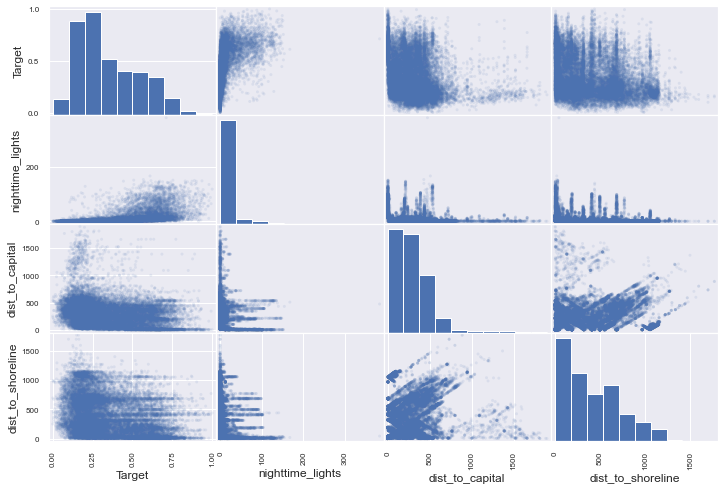

In [20]:
attributes = ["Target","nighttime_lights", "dist_to_capital", "dist_to_shoreline"]
pd.plotting.scatter_matrix(train_df[attributes], figsize=(12, 8), alpha=0.1);

# Encoding

###### We will encode the object features using a frequency encoder

In [21]:
cat_features = ['country']
count_encoder = CountEncoder(cols=cat_features)
count_encoder.fit(train_df[cat_features])
train_df = train_df.join(count_encoder.transform(train_df[cat_features]).add_suffix('_count'))
count_encoder.fit(test_df[cat_features])
test_df = test_df.join(count_encoder.transform(test_df[cat_features]).add_suffix('_count'))

In [22]:
cat_features = ['year', 'urban_or_rural']
count_encoder = CountEncoder(cols=cat_features)
count_encoder.fit(train_df[cat_features])
train_df = train_df.join(count_encoder.transform(train_df[cat_features]).add_suffix('_count'))
test_df = test_df.join(count_encoder.transform(test_df[cat_features]).add_suffix('_count'))

###### Drop the the 'year' and 'urban_or_rural' after encoding them.

In [23]:
for dataset in (train_df,test_df):
    dataset.drop(['urban_or_rural','year'],axis=1,inplace=True)

# Feature Engineering

###### Firstly, we will drop the ID feature as that it doesn't give useful information.

In [24]:
for dataset in (train_df,test_df):
    dataset.drop(['ID'], axis = 1, inplace = True)

###### We will combine the built-houses features into a one feature.

In [25]:
for dataset in (train_df,test_df):
    dataset['all_ghsl'] = dataset['ghsl_built_pre_1975'] + dataset['ghsl_built_1975_to_1990'] + \
                              dataset['ghsl_built_1990_to_2000'] + dataset['ghsl_built_2000_to_2014']

###### We will add the landcover features.

In [26]:
for dataset in (train_df,test_df):
    dataset['all_landcover'] = dataset['landcover_crops_fraction'] + dataset['landcover_urban_fraction']

###### We will combine the water features into a one feature.

In [27]:
for dataset in (train_df,test_df):
    dataset['all_water'] = dataset['landcover_water_permanent_10km_fraction'] + \
                              dataset['landcover_water_seasonal_10km_fraction'] 

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  21454 non-null  object 
 1   ghsl_water_surface                       21454 non-null  float64
 2   ghsl_built_pre_1975                      21454 non-null  float64
 3   ghsl_built_1975_to_1990                  21454 non-null  float64
 4   ghsl_built_1990_to_2000                  21454 non-null  float64
 5   ghsl_built_2000_to_2014                  21454 non-null  float64
 6   ghsl_not_built_up                        21454 non-null  float64
 7   ghsl_pop_density                         21454 non-null  float64
 8   landcover_crops_fraction                 21454 non-null  float64
 9   landcover_urban_fraction                 21454 non-null  float64
 10  landcover_water_permanent_10km_fraction  21454

###### Look for correlations:

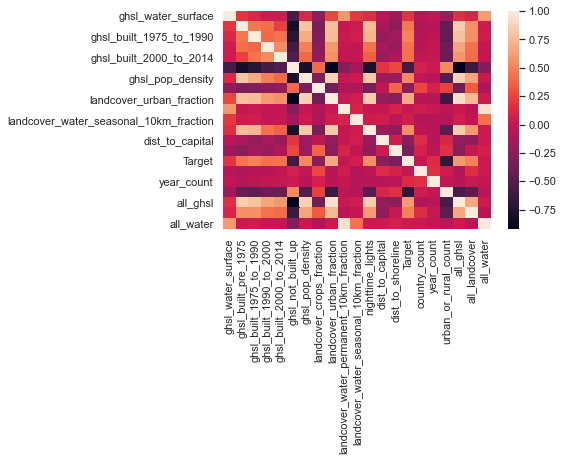

In [29]:
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix);

###### 'landcover_water_permanent_10km_fraction' looks like it has very high correlation with another feature, so we will drop it.

In [30]:
for dataset in (train_df,test_df):
    dataset.drop(['landcover_water_permanent_10km_fraction'],axis=1,inplace=True)

# ML Modeling

### Create a test set

In [31]:
validation = train_df.groupby('country').get_group('Malawi').reset_index(drop=True)
v2 = train_df.groupby('country').get_group('Cameroon').reset_index(drop=True)
v3 = train_df.groupby('country').get_group('Central African Republic').reset_index(drop=True)
v4 = train_df.groupby('country').get_group('Guinea').reset_index(drop=True)
v5 = train_df.groupby('country').get_group('Rwanda').reset_index(drop=True)
validation = pd.concat([validation,v2,v3,v4,v5],axis=0).reset_index(drop=True)

X = train_df.copy()

for x in range(0,train_df.shape[0]):
    if X['country'][x] in ['Malawi','Cameroon','Central African Republic','Guinea','Rwanda']:
        X.drop(index=x,inplace=True)

#drop the 'country' feature        
for dataset in (train_df,test_df,X,validation):
    dataset.drop(['country'],axis=1,inplace=True) 

### Prepare the model

In [32]:
y = X['Target']
X = X.drop('Target',axis=1)

In [33]:
lgbm = LGBMRegressor(learning_rate=0.05,num_iterations=1500,max_depth=4 ,num_leaves=150,
                              max_bins=85,min_data_in_leaf=30,reg_lambda=75)
log_lgbm = TransformedTargetRegressor(lgbm, func = np.log1p, inverse_func = np.expm1)

###### Use bagging to improve the model.

In [34]:
bag_reg = BaggingRegressor(log_lgbm, n_estimators=50, max_samples=4000, bootstrap=True, n_jobs=-1, random_state=988)
bag_reg.fit(X,y)
y_pred = bag_reg.predict(validation.drop('Target',axis=1))
error =mean_squared_error(y_pred,validation['Target'])
math.sqrt(error)

0.10861179018901897

###### Get the submission file.

In [35]:
bag_reg.fit(train_df.drop('Target',axis=1),train_df['Target'])
test_df['Target'] = bag_reg.predict(test_df)
submission = pd.DataFrame({"ID": ID ,"Target": test_df.Target})
submission['Target'] = np.clip(submission['Target'], 0.15, 1.0)
submission.to_csv('Economic.csv',index=False)

### Leaderboard RMSE: 0.1039661172059555